### Brenntag Data Scientist Assessment

The supply chain managers have asked you to help them estimate how much demand for their products (the main ingredients of gummy bears) there will be in the future, to help them make better decisions on how much they should order from the manufacturers of those products. If they have too much stock the product will expire, but if they have too little stock they won't be able to supply all customers. Additional challenge is that for some materials, they have to know far in advance how much the demand will be, as lead times can be long.

Key question they would like to answer: How much product should they order for the upcoming months?

They have supplied you with two datasets, one on historic orders for a selection of products, and one dataset with historic and forward-looking inflation figures.

The goal of the assessment is to assess how well you can work on a data science use-case end to end. We're therefore very much interested in not only the outcome - the goal is not to build the ultimate model - but also the process: how do you convert the business question into analysis and a model, what steps do you take to get to your conclusion, what choices do you make and why. Finally, we also want to assess how well you can present results to business colleagues.  

We expect you to deliver at least the following:  
(1) A script containing a predictive model  
(2) A csv containing per product a recommendation for how much the PMs should order, and when  
(3) A powerpoint presentation of at most 6 slides: Management presentation, with your interpretation of the assignment, key assumptions, results/conclusions, and recommendations. Your target audience here is the supply chain manager for the products for which you make the analysis. 

In the interview, we will ask you to present (3) in at most 20 minutes, and we will also ask you to explain to your colleague Data Scientist(s) your code; e.g. techniques used, findings and data science recommendations. 


If you have any questions while working on this assessment, feel free to reach out!

In [21]:
# import packages
import pandas as pd
import numpy as np

# plot
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# model
from catboost import CatBoostRegressor
from fbprophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

In [22]:
# # # !pip install catboost
# # #!pip install pystan
# # !pip install pystan==2.18.0.0
# # #!pip install fbprophet==0.6
# !pip install fbprophet==0.6

# #!pip install pystan==2.18.0.0

### Data dictionary 

Columns:

**order_id** - identifier of order  
**order placement date** - date the order was placed at Brenntag  
**requested delivery date** - date requested by the customer for the order to be delivered
**order delivery date** - actual delivery date  
**order quantity** - amount that was ordered, unit is specified in other column  
**quantity unit** - unit for the order quantity  
**product name** - product name  
**product_id** - product id  
**country** - Brenntag operating country for the order  
**origin_region** - Either EU or APAC - some products are sourced from manufacturers in the APAC region. These orders have a longer lead time of up to 90 days. For the EU these lead times are usually under 14 days  
**warehouse** - Warehouse from which the order was fulfilled  
**company_id** - id of customer company placing the order at Brenntag


### Data load

In [28]:
# Read in order data and external inflation data
order_data = pd.read_csv('product_order_data.csv')
inflation_data = pd.read_csv('OECD_inflation_forecast.csv')

## Step1. Data preprocessing

In [29]:
def preprocessing(df):
    
    '''Order data is processed'''
    
    # adjust the quantity to same scale --> KG accross products and added a new columns called aligned_qunatity_KG
    df['aligned_qunatity_KG'] = df['order_quantity']
    df['aligned_qunatity_KG'] = np.where(df.quantity_unit == "G", df.aligned_qunatity_KG/1000, df.aligned_qunatity_KG)
    df['aligned_qunatity_KG'] = np.where(df.quantity_unit == "MT", df.aligned_qunatity_KG*1000, df.aligned_qunatity_KG)

    ## let us align the name of countries to inflation data,
    # helpful for join as well
    df.replace({'country': {"United Kingdom": "UK", "The Netherlands": "NL", "France" : "FR"}}, inplace=True)
    
    # create the proper dates
    df["order_delivery_date"] = pd.to_datetime(df["order_delivery_date"])
    df['date'] =  df["order_delivery_date"].dt.strftime('%Y-%m-01')
    df['date'] = pd.to_datetime(df['date'])
    
    ## check the impact of removing below & equal 10 KG  - Business confirmation will be asked for this case 
    # only 3 cases from old dates are impacted --> removed based on data analysis
    df  = df[df.aligned_qunatity_KG > 10]
    
    return df
    

In [30]:
def add_inflation_to_data(df, inflation_data):
    
    """merging the inflation data with the order dataset"""

    ## columns to merge the dataframe
    columns_merge = ['country', 'date' ]
    df['date'] = pd.to_datetime(df['date'])
    
    # convert the inflation date properly with the date format
    inflation_data['date'] =  pd.to_datetime(inflation_data['start_of_month'], format='%d-%m-%Y')
    
    ## swelect the relevant data and join with order dataset 
    inflation_data_updated = inflation_data[['country', 'date', 'inflation']]
    #inflation_data_updated['date'] = pd.to_datetime(inflation_data_updated['date'])

    ## data merged 
    df = df.merge(inflation_data_updated, on=columns_merge, how="left")
    
    print("Shape of prepared dataset is", df.shape[0])

    return df
    

In [31]:
## execute the data preparation

df = preprocessing(order_data)
df = add_inflation_to_data(df, inflation_data=inflation_data)
df.head(2)

Shape of prepared dataset is 8361


,order_placement_date,requested_delivery_date,order_delivery_date,order_quantity,quantity_unit,product_name,material_id,country,origin_region,warehouse_names,company_id,order_id,aligned_qunatity_KG,date,inflation
0,2020-08-13,2020-09-08,2020-09-08,1000.0,KG,Citric Acid,E235421,UK,EU,Lutterworth,COER82357,23c60cjbmuvhgqk820ps,1000.0,2020-09-01,-0.81012
1,2020-09-15,2020-09-22,2020-09-22,100.0,KG,Citric Acid,E235421,UK,EU,Bristol,COIU94847,5i5ftojtbpgt9967st8l,100.0,2020-09-01,-0.81012


## Feature engineering 

In this section, we are going few extra features to our dataset --> Drived features. 

In [32]:
## what is the normal days of leg between order placemennt to delivery 
## for this we need to have two extra features 
## improve the datetype
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'])
df['order_placement_date'] = pd.to_datetime(df['order_placement_date'])

df['leg_delivery'] = df['requested_delivery_date'] - df['order_delivery_date']
df['leg_delivery'] = df['leg_delivery'].apply(lambda x: x.days) # converting it into numbers 
 ## if negative then order was delayed 

In [33]:
## how far the delivery date is from booked date -- no. of days of delivery 
df['booking_distance'] = df['requested_delivery_date'] - df['order_placement_date']
df['booking_distance'] = df['booking_distance'].apply(lambda x: x.days) # converting it into numbers 

In [34]:
## add month and year columns
df['month'] = df['order_placement_date'].dt.month
df['year'] = df['order_placement_date'].dt.year
df['week'] = df['order_placement_date'].dt.week

In [35]:
# # Sales trend over the months and year
# sns.factorplot(data = df, x ="date", y = "aligned_qunatity_KG", 
#                col = 'origin_region', hue="product_name")

## Model Decisions 

#### Approach 1.
We have full segregation based on APAC -- 1 Product and EU -- 2 Products, so we could forecast inventory needs for two regions.

#### Approach 2 .
We create models for each product so 3 models.
 
Timeframe - 6 months forward [Business inputs are needed here, but I am going with 6 months - short term]

Conclusion - I am going with approach 2

In [36]:
## let us check the seasonality and trend in time series 
## using ACF and pacf
# ## we use baseline model -
# Linear regression ( ridge regression first, elasticnet) -- I will skip it
# ARIMA
# Catboost
# FBprophet

In [37]:
### create three datasets  with monthly data 
citric = df[df.product_name =="Citric Acid"]
citric = citric.groupby(['date']).agg({"inflation" : "mean", "aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of citric daatset", citric.shape)

sugar =  df[df.product_name =="Sugar"]
sugar = sugar.groupby(['date']).agg({"inflation" : "mean", "aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of sugar daatset", sugar.shape)

print("gelatin is comoing from APAC and has lead time upto 90 days, so can make monthly forecast")
gelatin =  df[df.product_name =="Gelatin"]
gelatin = gelatin.groupby(['date']).agg({"inflation" : "mean", "aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of gelatin daatset", gelatin.shape)

Shape of citric daatset (76, 3)
Shape of sugar daatset (76, 3)
gelatin is comoing from APAC and has lead time upto 90 days, so can make monthly forecast
Shape of gelatin daatset (78, 3)


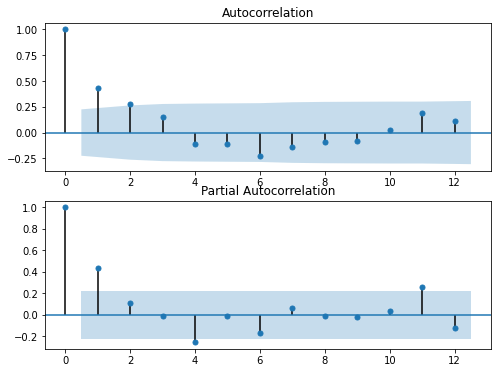

In [38]:
## ACF test
# convert the date column to a DatetimeIndex object
data = citric[['date', "aligned_qunatity_KG"]]
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# plot the ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(data, ax=ax1, lags=12)
plot_pacf(data, ax=ax2, lags=12)
plt.show()

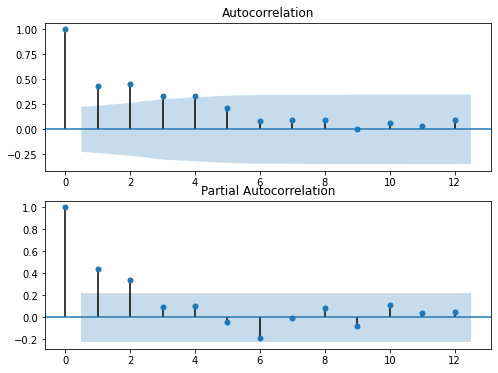

In [39]:
## ACF test
# convert the date column to a DatetimeIndex object
data = sugar[['date', "aligned_qunatity_KG"]]
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# plot the ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(data, ax=ax1, lags=12)
plot_pacf(data, ax=ax2, lags=12)
plt.show()

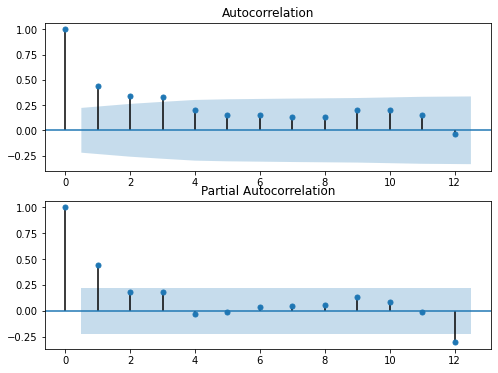

In [40]:
## ACF test
# convert the date column to a DatetimeIndex object
data = gelatin[['date', "aligned_qunatity_KG"]]
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# plot the ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(data, ax=ax1, lags=12)
plot_pacf(data, ax=ax2, lags=12)
plt.show()

In [41]:
## Note -  it is not very clear, lets do decomposition test 

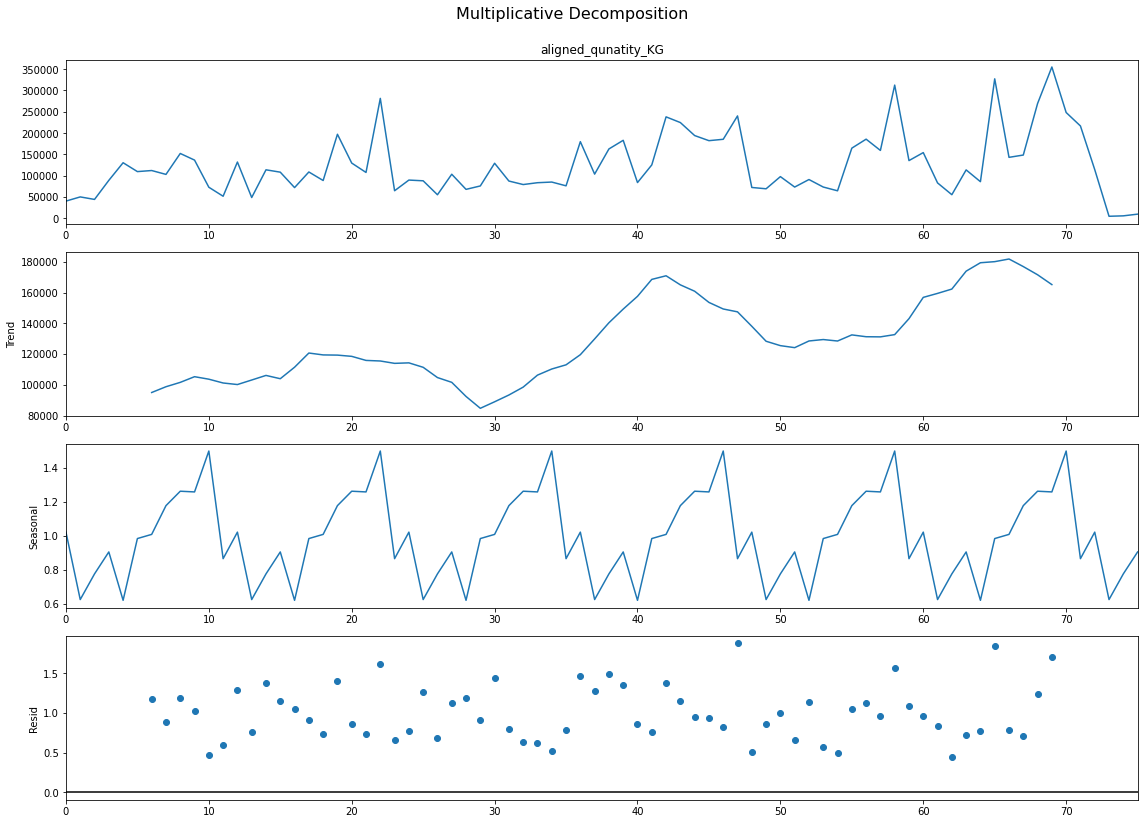

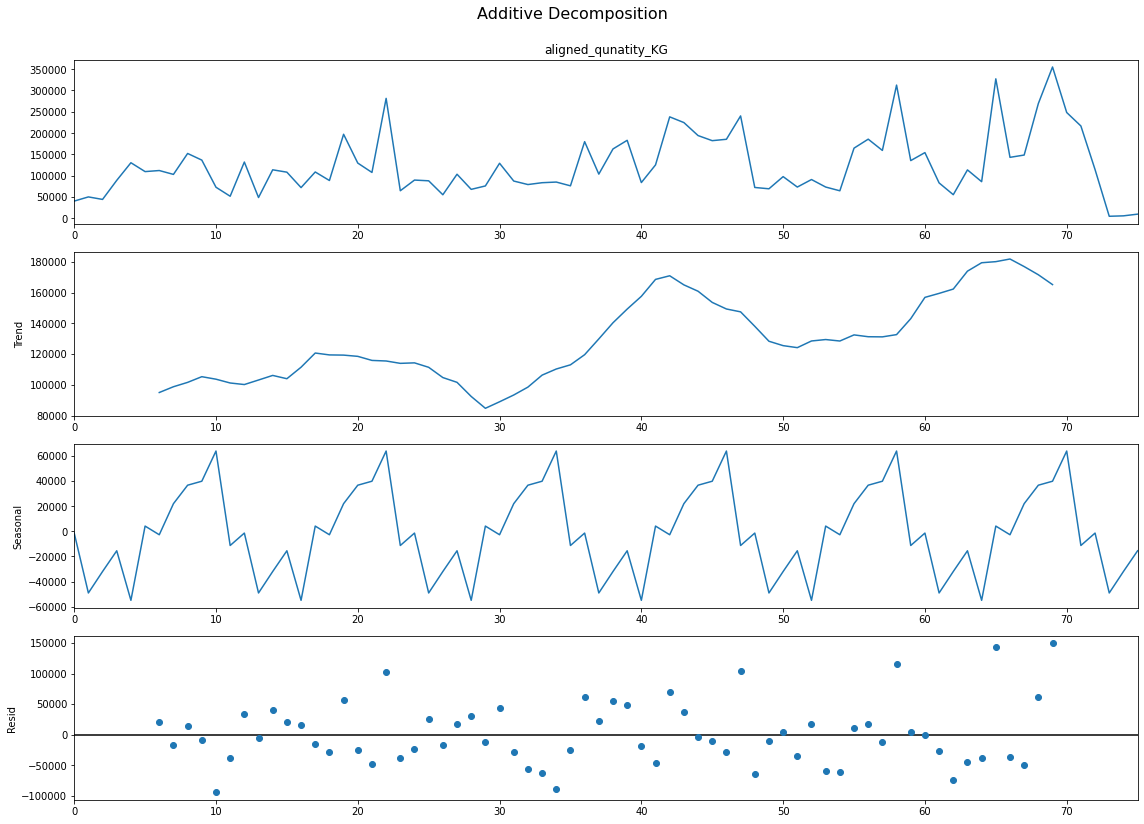

In [42]:
## test the seasonlity and trend in the the data
## testing citric product
# citric = citric.set_index('date')

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(citric['aligned_qunatity_KG'], model='multiplicative', period=12)

# Additive Decomposition
additive_decomposition = seasonal_decompose(citric['aligned_qunatity_KG'], model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## quite a lot seasconality and clear trend

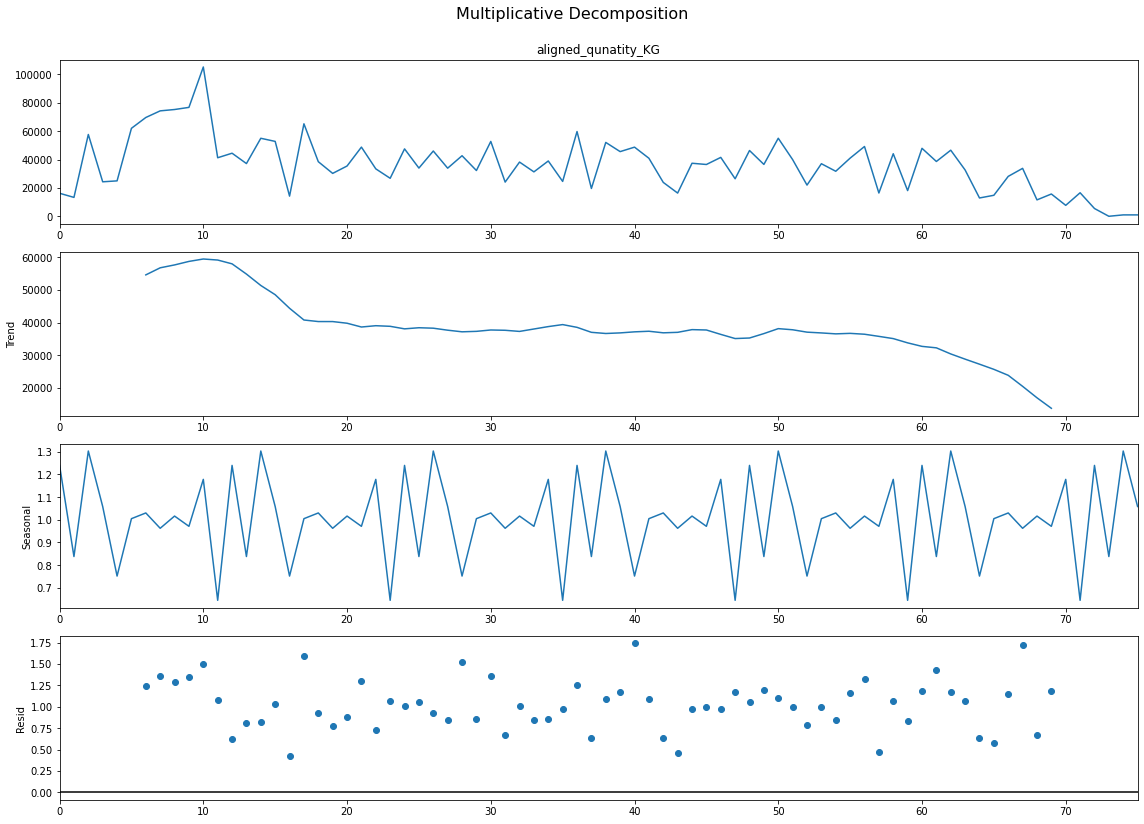

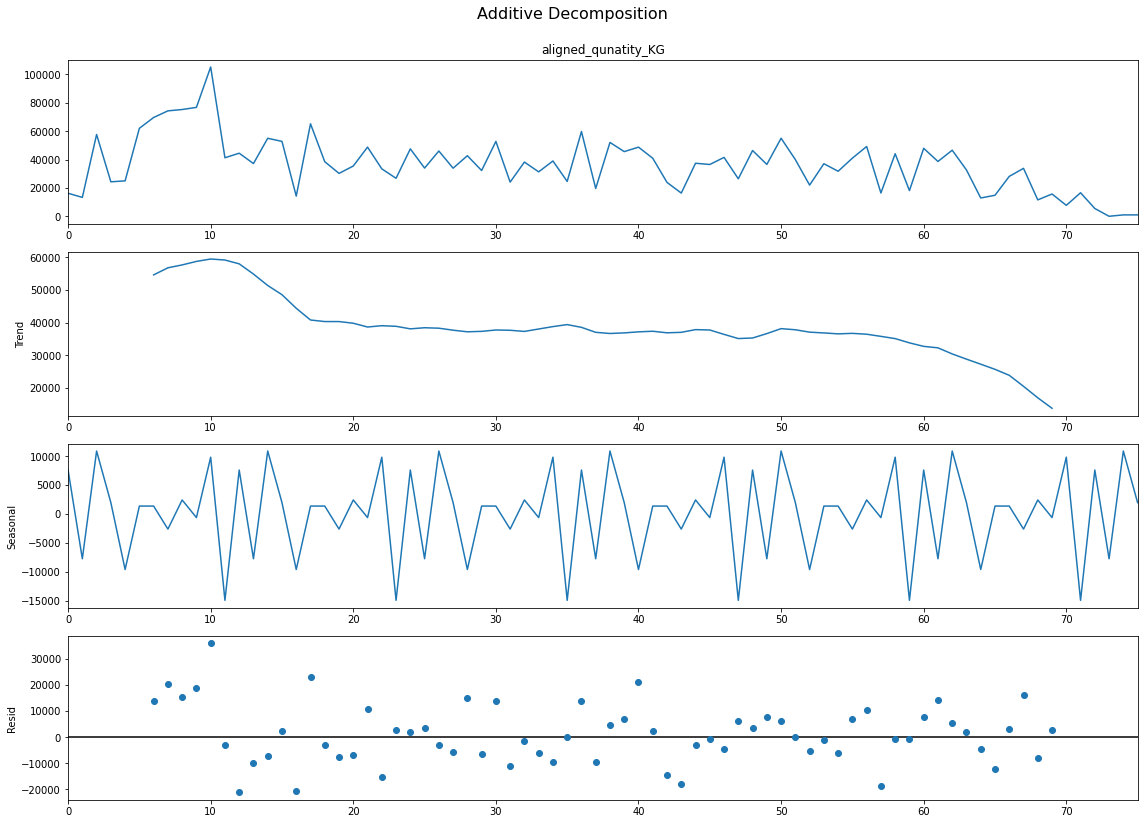

In [43]:
## test the seasonlity and trend in the the data
## testing sugar product
# sugar = sugar.set_index('date')

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(sugar['aligned_qunatity_KG'], model='multiplicative', period=12)

# Additive Decomposition
additive_decomposition = seasonal_decompose(sugar['aligned_qunatity_KG'], model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## quite a lot seasconality and clear downtrend

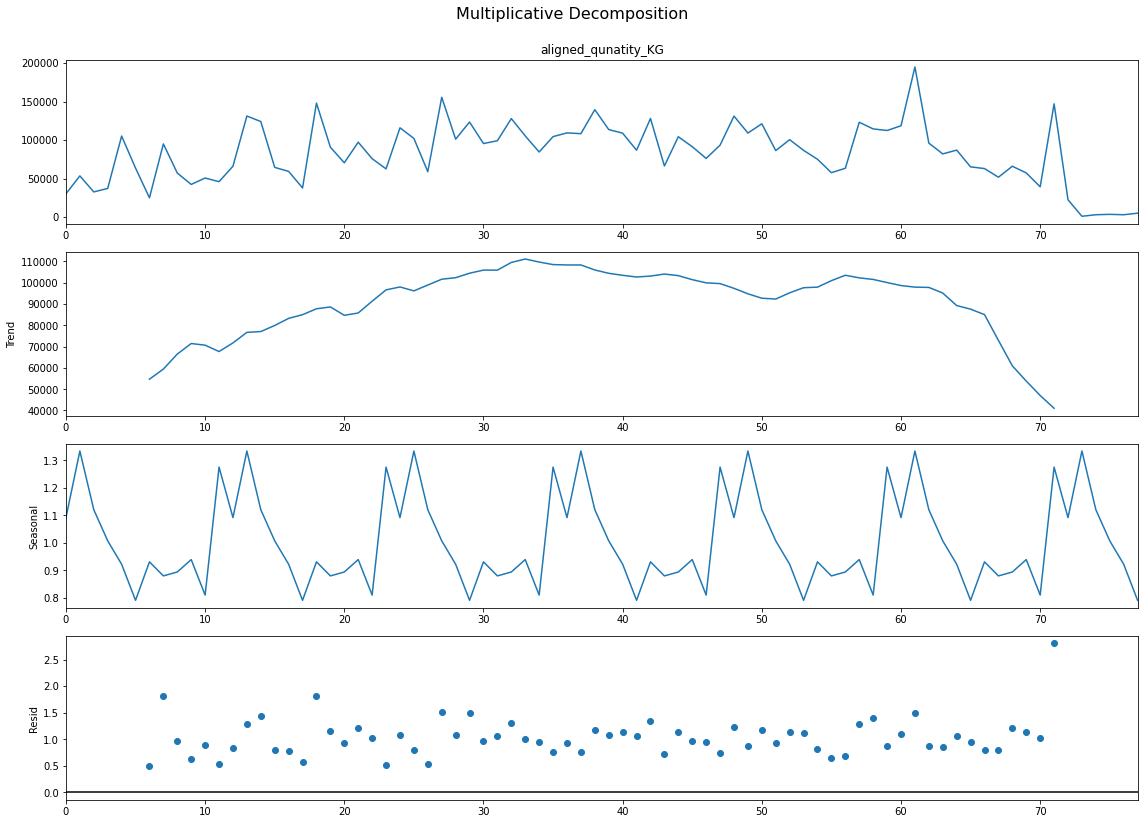

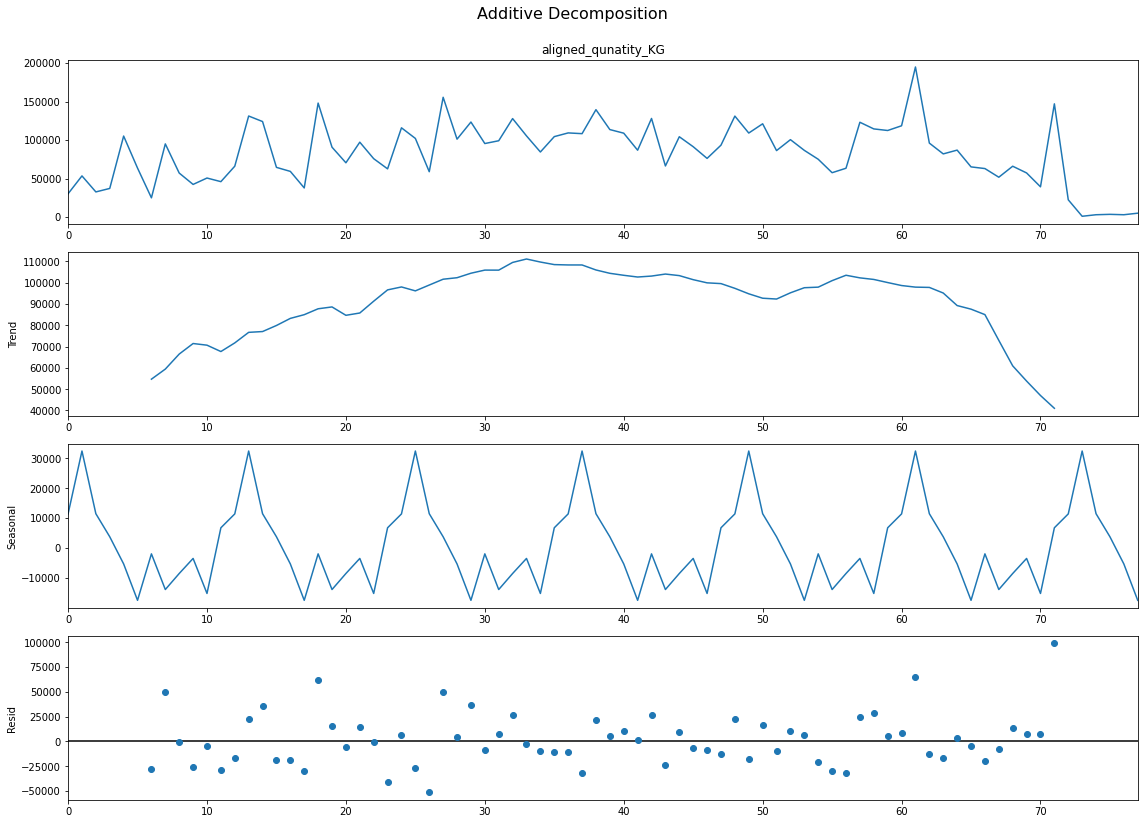

In [44]:
## test the seasonlity and trend in the the data
## testing gelatin product

# Multiplicative Decomposition on 12 months lag
multiplicative_decomposition = seasonal_decompose(gelatin['aligned_qunatity_KG'], model='multiplicative', period=12)

# Additive Decomposition
additive_decomposition = seasonal_decompose(gelatin['aligned_qunatity_KG'], model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## quite a lot seasconality and mix trend

## Baseline model 

In [45]:
df.head()

,order_placement_date,requested_delivery_date,order_delivery_date,order_quantity,quantity_unit,product_name,material_id,country,origin_region,warehouse_names,company_id,order_id,aligned_qunatity_KG,date,inflation,leg_delivery,booking_distance,month,year,week
0,2020-08-13,2020-09-08,2020-09-08,1000.0,KG,Citric Acid,E235421,UK,EU,Lutterworth,COER82357,23c60cjbmuvhgqk820ps,1000.0,2020-09-01,-0.810120,0,26,8,2020,33
1,2020-09-15,2020-09-22,2020-09-22,100.0,KG,Citric Acid,E235421,UK,EU,Bristol,COIU94847,5i5ftojtbpgt9967st8l,100.0,2020-09-01,-0.810120,0,7,9,2020,38
2,2020-04-02,2020-06-02,2020-06-02,2196.0,KG,Gelatin,E164938,NL,APAC,Enschede,COVQ64536,i72w4oebmqpjbmwmnohg,2196.0,2020-06-01,1.163027,0,61,4,2020,14
3,2019-09-16,2019-09-19,2019-09-19,25.0,KG,Citric Acid,E235421,UK,EU,Bristol,COBE05528,3vtl1drz0xv6ddd27d9a,25.0,2019-09-01,0.144040,0,3,9,2019,38
4,2019-06-13,2019-08-01,2019-08-01,2000000.0,G,Citric Acid,E235421,UK,EU,Bristol,COQZ30137,lk7ybzgazni37zcgacep,2000.0,2019-08-01,0.245515,0,49,6,2019,24


In [46]:
### create three datasets  with monthly data 
citric = df[df.product_name =="Citric Acid"]
citric = citric.groupby(['date']).agg({"inflation" : "mean", "aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of citric daatset", citric.shape)


sugar =  df[df.product_name =="Sugar"]
sugar = sugar.groupby(['date']).agg({"inflation" : "mean", "aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of sugar daatset", sugar.shape)

print("gelatin is comoing from APAC and has lead time upto 90 days, so can make monthly forecast")
gelatin =  df[df.product_name =="Gelatin"]
gelatin = gelatin.groupby(['date']).agg({"inflation" : "mean", "aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of gelatin daatset", gelatin.shape)

Shape of citric daatset (76, 3)
Shape of sugar daatset (76, 3)
gelatin is comoing from APAC and has lead time upto 90 days, so can make monthly forecast
Shape of gelatin daatset (78, 3)


In [47]:
### Model iteration 1 

In [48]:
## ARIMA model for Citric
# for citric products
forecast = citric[['aligned_qunatity_KG', "date"]]
forecast = forecast.set_index("date")

# Create train and test sets
train_size = int(len(forecast) * 0.8)
train, test = forecast[:train_size], forecast[train_size:]

# Fit the model
model = ARIMA(train, order=(5,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))[0]

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - test.values)**2))
mape = np.mean((predictions-test.values) *100/predictions)
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

## RMSE is too high for the model

RMSE: 107177.24195414232
MAPE: 4.5750332611626945


In [49]:
## ARIMA model for Sugar
forecast = sugar[['aligned_qunatity_KG', "date"]]
forecast = forecast.set_index("date")

# Create train and test sets
train_size = int(len(forecast) * 0.8)
train, test = forecast[:train_size], forecast[train_size:]

# Fit the model
model = ARIMA(train, order=(5,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))[0]

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - test.values)**2))
mape = np.mean((predictions-test.values) *100/predictions)
print(f'Sugar RMSE: {rmse}')
print(f'MAPE: {mape}')


Sugar RMSE: 23102.285983693448
MAPE: 46.37787291691217


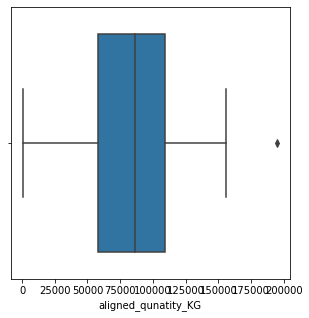

In [50]:
## gelation has oultiers  which is qunatity greater than 175k, we remove it else MAPE will be suffering
plt.figure(figsize=(5,5))
sns.boxplot(gelatin.aligned_qunatity_KG)

In [51]:
## ARIMA model for Gelnatin

gelatin = gelatin[gelatin.aligned_qunatity_KG < 175000]
forecast = gelatin[['aligned_qunatity_KG', "date"]]
forecast = forecast.set_index("date")

# Create train and test sets
train_size = int(len(forecast) * 0.8)
train, test = forecast[:train_size], forecast[train_size:]

# Fit the model
model = ARIMA(train, order=(5,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))[0]

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - test.values)**2))
mape = np.mean((abs(predictions-test.values)) *100/predictions)
print(f'Sugar RMSE: {rmse}')
print(f'MAPE: {mape}')

# not a good model so we need to change the modelling now. 

Sugar RMSE: 50577.91562051245
MAPE: 52.49037227875772


In [52]:
## model 2 - Catboost Regressor - one model for all
#!pip install catboost

In [53]:
df = df.reset_index()

In [54]:
## testing out catboost algo. for the problem statement 
feature_set = ["date", 'product_name',  'aligned_qunatity_KG',
       'inflation', 'leg_delivery', 'booking_distance',]

## we dont need to do indivuail level forecast as catboost will take care of category
catboost_df = df[feature_set]
catboost_df["date"] = catboost_df["date"].dt.strftime('%Y-%m-01')

cat_features= ['product_name']


# specify the target column for forecasting
target_col = 'aligned_qunatity_KG'
# split the data into training and testing sets
train_size = int(len(catboost_df) * 0.8)

train_df = catboost_df[catboost_df.date < "2022-10-01"]
test_df = catboost_df[catboost_df.date >= "2022-10-01"]

# specify the model parameters
model = CatBoostRegressor(iterations=200,
                          cat_features=cat_features,
                          learning_rate=0.1, loss_function='RMSE')

# fit the model to the training data
model.fit(train_df.drop([target_col, "date"], axis=1), train_df[target_col], verbose=False)

In [55]:
# make predictions for the future dates using the trained model
X_test = test_df.drop(["aligned_qunatity_KG", "date"], axis=1)
test_df["pred"] = model.predict(X_test)

In [56]:
# combine the training and testing data with the predicted future values
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(test_df.pred, test_df.aligned_qunatity_KG)*100) 

# not a good model 

109.61405907136141


In [57]:
## for each product line 
sugar = test_df[test_df.product_name =="Sugar"]
print(mean_absolute_percentage_error(sugar.pred, sugar.aligned_qunatity_KG)*100)

72.87508174031784


In [58]:
## for each product line 
citric = test_df[test_df.product_name =="Citric Acid"]

print(mean_absolute_percentage_error(citric['pred'], citric.aligned_qunatity_KG)*100)

# this could be inlfluenced by outliers 

121.67099858917865


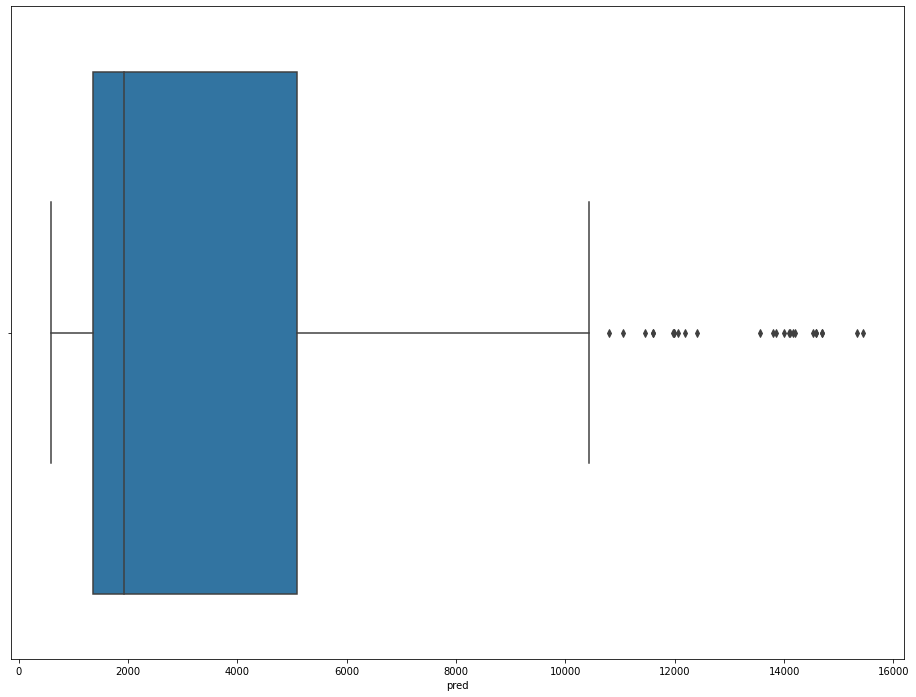

In [59]:
sns.boxplot(test_df.pred)

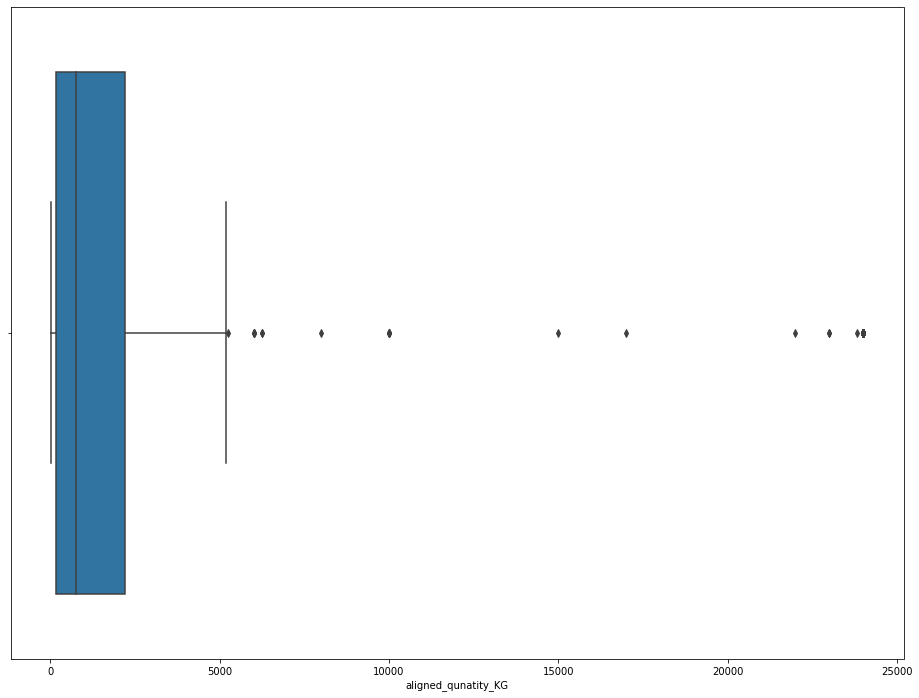

In [60]:
sns.boxplot(test_df.aligned_qunatity_KG) ## if we remove the outliers and check the model 

In [61]:
test_df = test_df[test_df.aligned_qunatity_KG < 10000]
print(mean_absolute_percentage_error(test_df['pred'], test_df.aligned_qunatity_KG)*100)

71.5199071048226


In [62]:
## model 3  --> This model is quite good
# fbprophet
#!pip install fbprophet

In [63]:
### create three datasets  with monthly data 
citric = df[df.product_name =="Citric Acid"]
citric = citric.groupby(['date']).agg({"aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of citric daatset", citric.shape)

sugar =  df[df.product_name =="Sugar"]
sugar = sugar.groupby(['date']).agg({ "aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of sugar daatset", sugar.shape)

print("gelatin is comoing from APAC and has lead time upto 90 days, so can make monthly forecast")
gelatin =  df[df.product_name =="Gelatin"]
gelatin = gelatin.groupby(['date']).agg({"aligned_qunatity_KG": "sum"}).reset_index()
print("Shape of gelatin daatset", gelatin.shape)

Shape of citric daatset (76, 2)
Shape of sugar daatset (76, 2)
gelatin is comoing from APAC and has lead time upto 90 days, so can make monthly forecast
Shape of gelatin daatset (78, 2)


In [64]:
# pip install fbprophet==0.6

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


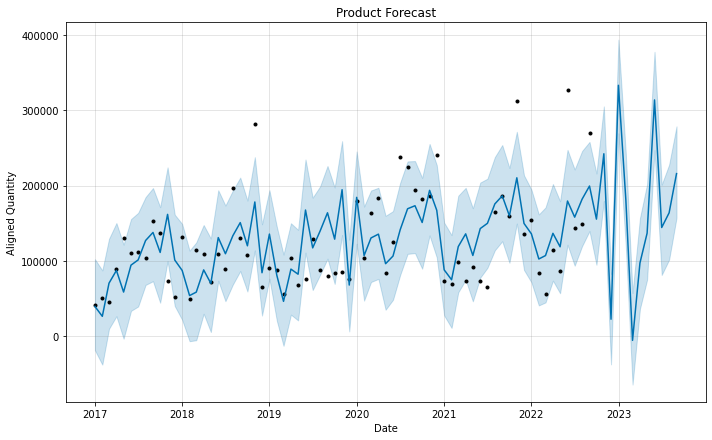

In [66]:
# citric
citric['ds'] = pd.to_datetime(citric['date'])
train_data = citric[citric.date < "2022-10-01"]
test_data = citric[citric.date >= "2022-10-01"]

# make it ready for modelling 
train_data['y'] = train_data["aligned_qunatity_KG"]
train_data['ds'] = train_data["ds"]

# Fit the model
model = Prophet()
model.fit(train_data)

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)
forecast["y"] = citric["aligned_qunatity_KG"]

# Plot the forecast
model.plot(forecast, xlabel='Date', ylabel='Aligned Quantity')
plt.title('Product Forecast')
plt.show()

In [67]:
# Calculate MAPE
forecast_validation = forecast[['ds',"y", "yhat"]]
forecast_validation = forecast_validation[(forecast_validation['ds'] >= "2022-10-01") & (forecast_validation['ds'] >= "2023-02-01")]
forecast_validation = forecast_validation.dropna()

mape = np.mean(np.abs(forecast_validation['y'] - forecast_validation['yhat']) / forecast_validation['y']) * 100
print('MAPE:', mape)

from sklearn.metrics import r2_score
print(r2_score(forecast_validation['y'], forecast_validation['yhat']))

MAPE: 533.7985449131254
-962.8430574380355


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


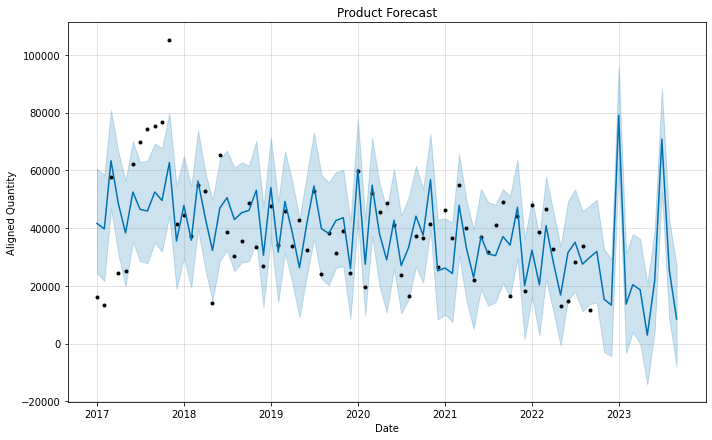

In [68]:
# Sugar
sugar['ds'] = pd.to_datetime(sugar['date'])
train_data = sugar[sugar.date < "2022-10-01"]
test_data = sugar[sugar.date >= "2022-10-01"]

# make it ready for modelling 
train_data['y'] = train_data["aligned_qunatity_KG"]
train_data['ds'] = train_data["ds"]

# Fit the model
model = Prophet()
model.fit(train_data)

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)
forecast["y"] = citric["aligned_qunatity_KG"]

# Plot the forecast
model.plot(forecast, xlabel='Date', ylabel='Aligned Quantity')
plt.title('Product Forecast')
plt.show()

In [69]:
# Calculate MAPE
forecast_validation = forecast[['ds',"y", "yhat"]]
forecast_validation = forecast_validation[(forecast_validation['ds'] >= "2022-10-01") & (forecast_validation['ds'] >= "2023-02-01")]
forecast_validation = forecast_validation.dropna()

mape = np.mean(np.abs(forecast_validation['y'] - forecast_validation['yhat']) / forecast_validation['y']) * 100
print('MAPE:', mape)

from sklearn.metrics import r2_score
print(r2_score(forecast_validation['y'], forecast_validation['yhat']))

MAPE: 163.03471598017893
-34.179844492788206


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


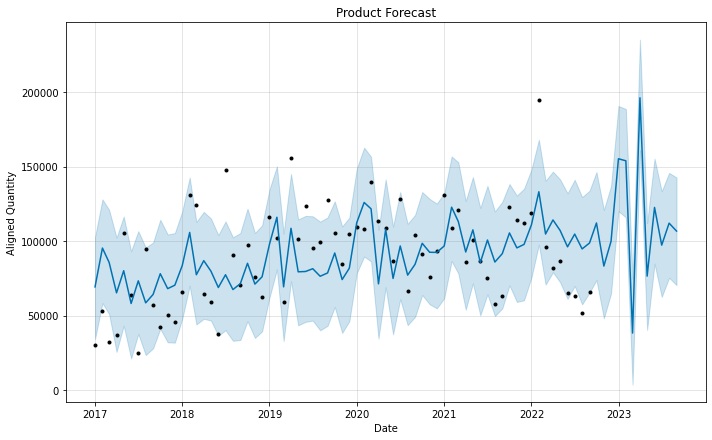

In [70]:
# for gelatin
gelatin['ds'] = pd.to_datetime(gelatin['date'])
train_data = gelatin[gelatin.date < "2022-10-01"]
test_data = gelatin[gelatin.date >= "2022-10-01"]

# make it ready for modelling 
train_data['y'] = train_data["aligned_qunatity_KG"]
train_data['ds'] = train_data["ds"]

# Fit the model
model = Prophet()
model.fit(train_data)

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)
forecast["y"] = citric["aligned_qunatity_KG"]

# Plot the forecast
model.plot(forecast, xlabel='Date', ylabel='Aligned Quantity')
plt.title('Product Forecast')
plt.show()

In [71]:
# Calculate MAPE
forecast_validation = forecast[['ds',"y", "yhat"]]
forecast_validation = forecast_validation[(forecast_validation['ds'] >= "2022-10-01") & (forecast_validation['ds'] >= "2023-02-01")]
forecast_validation = forecast_validation.dropna()

mape = np.mean(np.abs(forecast_validation['y'] - forecast_validation['yhat']) / forecast_validation['y']) * 100
print('MAPE:', mape)

from sklearn.metrics import r2_score
print(r2_score(forecast_validation['y'], forecast_validation['yhat']))

MAPE: 1200.1481264903055
-4458.799793813397


In [72]:
## Conclusion - FBprophet perfroms very bad on metrics, we need to do more experiements 

## Next steps
1. We can do experiments with boosting, LSTM, etc to get the better results. 
2. There are missing months when no transaction happen, we can find better ways to imputes those months
3. Further we can test out few rule based approcahes. - model should never recommend higher that annual max etc. these are few points we can dsicuss with bsuiness team